In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

In [2]:
data = pd.read_csv('emails.csv', encoding='latin1')

In [3]:
data[:5]

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
data['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [5]:
print('결측값 여부: ', data.isnull().values.any())

결측값 여부:  False


# stopwords 제거

In [ ]:
import nltk
import string
import re
def text_process(text):
    text = re.sub("Subject","",text)
    text = text.translate(str.maketrans('','',string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)
data['text'] = data['text'].apply(text_process)
data[:5]

In [7]:
text = pd.DataFrame(data['text'])
spam = pd.DataFrame(data['spam'])

In [8]:
print(text)

                                                   text
0     naturally irresistible corporate identity lt r...
1     stock trading gunslinger fanny merrill muzo co...
2     unbelievable new homes made easy im wanting sh...
3     4 color printing special request additional in...
4     money get software cds software compatibility ...
...                                                 ...
5723  research development charges gpg forwarded shi...
5724  receipts visit jim thanks invitation visit lsu...
5725  enron case study update wow day super thank mu...
5726  interest david please call shirley crenshaw as...
5727  news aurora 5 2 update aurora version 5 2 fast...

[5728 rows x 1 columns]


In [9]:
print(spam)

      spam
0        1
1        1
2        1
3        1
4        1
...    ...
5723     0
5724     0
5725     0
5726     0
5727     0

[5728 rows x 1 columns]


# CountVectorizer

In [10]:
from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  37228


In [11]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:50])

['enron', 'ect', 'vince', 'hou', 'com', 'please', '2000', 'kaminski', 'subject', 'would', 'cc', 'j', '1', 'pm', '2001', '2', 'time', 'research', '10', 'thanks', 'know', 'may', '3', 'group', 'information', 'new', 'e', 'energy', 'like', 'risk', 'one', 'business', 'get', 'power', '00', 'email', 'let', 'us', 'also', '0', 'message', '5', 'mail', 'need', 'meeting', '11', '01', '30', 'corp', 'company']


In [12]:
vocab_size = len(vocab)
word2idx = {}

for i, word in enumerate(vocab):
    word2idx[word] = i

In [13]:
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [14]:
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape

(5728, 37228)

# TF-IDF Vectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5728, 37187)

In [16]:
features = vectors

# train set & test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, data['spam'], test_size=0.15, random_state=111)

# sklearn Classifiers 이용

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [19]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [20]:
cm = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [21]:
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [22]:
pred_scores_word_vectors = []
for k,v in cm.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

# TF-IDF Vectorizer 알고리즘을 사용한 예측

In [23]:
pred_scores_word_vectors

[('SVC', [0.9941860465116279]),
 ('KN', [0.9732558139534884]),
 ('NB', [0.9906976744186047]),
 ('DT', [0.963953488372093]),
 ('LR', [0.9755813953488373]),
 ('RF', [0.9732558139534884])]

# Confusion Matrix(혼동 행렬) 확인

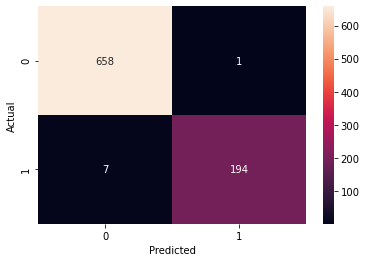

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_nb = mnb.predict(X_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots()
sns.heatmap(cm,annot = True,fmt = ".0f")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()